In [1]:
import os
import json

import fiftyone as fo
import fiftyone.zoo as foz

import pandas as pd
from sklearn.model_selection import train_test_split

from loguru import logger

## Download COCO-2017 dataset

**Classes:**
  * person
  * car
  * bicycle
  * motorcycle
  * bus
  * truck


In [2]:
selected_classes = [
    "person", "car", "bicycle",
    "motorcycle", "bus", "truck"
]
dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["train", "validation"],
    classes=selected_classes,
    max_samples=10000,
    only_matching=True,
)


session = fo.launch_app(dataset, auto=False)
session

Found annotations at '/home/pyml/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at '/home/pyml/fiftyone/coco-2017/raw/instances_val2017.json'
Only found 2968 (<10000) samples matching your requirements
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'train'
 100% |█████████████| 10000/10000 [15.2s elapsed, 0s remaining, 1.1K samples/s]       
Loading 'coco-2017' split 'validation'
 100% |███████████████| 2968/2968 [3.5s elapsed, 0s remaining, 847.7 samples/s]      
Dataset 'coco-2017-train-validation-10000' created
Session launched. Run `session.show()` to open the App in a cell output.


Dataset:          coco-2017-train-validation-10000
Media type:       image
Num samples:      12968
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [3]:
sample = dataset.first()

sample

<Sample: {
    'id': '66fdd3376feb3a3365bf65c6',
    'media_type': 'image',
    'filepath': '/home/pyml/fiftyone/coco-2017/train/data/000000001315.jpg',
    'tags': ['train'],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 480,
        'height': 640,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '66fdd3366feb3a3365bf65bb',
                'attributes': {},
                'tags': [],
                'label': 'bicycle',
                'bounding_box': [
                    0.9574374999999999,
                    0.55921875,
                    0.042562499999999996,
                    0.10275000000000001,
                ],
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'vehicle',
                'iscrowd': 0,
            }>,
            <Detection: 

## Preparing annotations for Faster-RCNN

 * using custom json format

In [4]:
annot_json_dir = "data/annotations/json"
os.makedirs(annot_json_dir, exist_ok=True)

list_samples = []

for sample in dataset:
    if sample["ground_truth.detections"] is None:
        continue
    filename = os.path.basename(sample["filepath"])

    img_width = sample["metadata"]["width"]
    img_height = sample["metadata"]["height"]
    labels = set([det["label"] for det in sample["ground_truth.detections"]])
    annots = []
    for det in sample["ground_truth.detections"]:
        label = det["label"]
        x, y, w, h = det["bounding_box"]
        x, y = int(x * img_width), int(y * img_height)
        w, h = int(w * img_width), int(h * img_height)
        if w > 0 and h > 0:
            annots.append({
                "label": label,
                "x": x, "y": y,
                "width": w, "height": h
            })

    label_path = os.path.join(
        annot_json_dir, filename.replace("jpg", "json")
    )
    with open(label_path, "w") as f:
        json.dump(annots, f)

    list_samples.append({
        "imagepath": sample["filepath"],
        "labelpath": label_path,
        "tag": sample["tags"][0]
    })
        
    #break

df = pd.DataFrame(list_samples)
df.head()

,imagepath,labelpath,tag
0,/home/pyml/fiftyone/coco-2017/train/data/00000...,data/annotations/json/000000001315.json,train
1,/home/pyml/fiftyone/coco-2017/train/data/00000...,data/annotations/json/000000022741.json,train
2,/home/pyml/fiftyone/coco-2017/train/data/00000...,data/annotations/json/000000043202.json,train
3,/home/pyml/fiftyone/coco-2017/train/data/00000...,data/annotations/json/000000061181.json,train
4,/home/pyml/fiftyone/coco-2017/train/data/00000...,data/annotations/json/000000095850.json,train


<Axes: title={'center': 'Number of samples per split'}, xlabel='tag'>

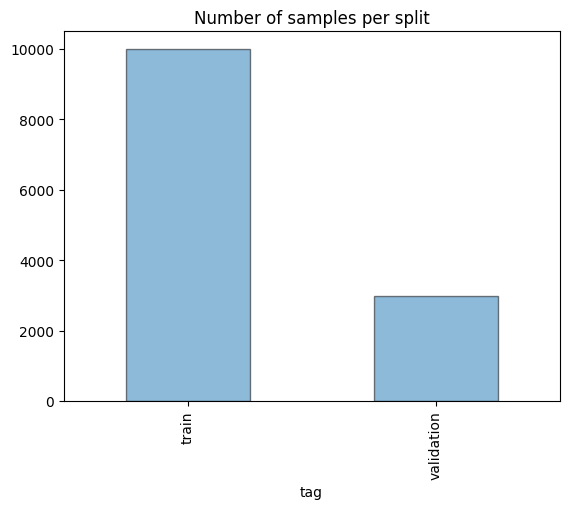

In [5]:
# bar plot of train/test/validation split
df["tag"].value_counts().plot(
    kind="bar", alpha=0.5, edgecolor="black",
    title="Number of samples per split"
)

In [6]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'validation'])}")


2024-10-02 18:12:20.697 | INFO     | __main__:<module>:1 - Number of samples: 12968
2024-10-02 18:12:20.701 | INFO     | __main__:<module>:2 - Number of Train samples: 10000
2024-10-02 18:12:20.703 | INFO     | __main__:<module>:3 - Number of Validation samples: 2968


In [7]:
# use current validation set as test set
df_test = df[df["tag"] == "validation"].reset_index(drop=True)
df_test["tag"] = "test"

# split train -> train/val (80%/20%)
df_train = df[df["tag"] == "train"].reset_index(drop=True)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
df_train["tag"] = "train"
df_val["tag"] = "val"

# concatenate
df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

df.to_csv("data/data.csv", index=False)

In [8]:
#dataset.delete()

In [9]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'val'])}")
logger.info(f"Number of Test samples: {len(df[df['tag'] == 'test'])}")


2024-10-02 18:12:20.749 | INFO     | __main__:<module>:1 - Number of samples: 12968
2024-10-02 18:12:20.751 | INFO     | __main__:<module>:2 - Number of Train samples: 8000
2024-10-02 18:12:20.752 | INFO     | __main__:<module>:3 - Number of Validation samples: 2000
2024-10-02 18:12:20.753 | INFO     | __main__:<module>:4 - Number of Test samples: 2968


### Prepare label files for YOLO

In [16]:
from PIL import Image

# yolo labels start from 0
label2idx = {
    "person": 0, "car": 1, "bicycle": 2,
    "motorcycle": 3, "bus": 4, "truck": 5
}

yolo_dir = "data/yolo_format"
yolo_imgtrain_dir = os.path.join(yolo_dir, "images", "train")
yolo_imgval_dir = os.path.join(yolo_dir, "images", "val")
yolo_labeltrain_dir = os.path.join(yolo_dir, "labels", "train")
yolo_labelval_dir = os.path.join(yolo_dir, "labels", "val")
os.makedirs(yolo_imgtrain_dir, exist_ok=True)
os.makedirs(yolo_imgval_dir, exist_ok=True)
os.makedirs(yolo_labeltrain_dir, exist_ok=True)
os.makedirs(yolo_labelval_dir, exist_ok=True)

def write_yolo_label(
        annots,
        img_width,
        img_height,
        output_path
    ):
    with open(output_path, "w") as f:
        for annot in annots:
            label = label2idx[annot["label"]]
            x = annot["x"] / img_width
            y = annot["y"] / img_height
            w = annot["width"] / img_width
            h = annot["height"] / img_height
            f.write(f"{label} {x:.4f} {y:.4f} {w:.4f} {h:.4f}\n")

## save images and labels
for _, row in df.iterrows():
    img_path = row["imagepath"]
    labe_json_path = row["labelpath"]
    tag = row["tag"]
    filename = os.path.basename(img_path)

    img = Image.open(img_path)
    img_width, img_height = img.size
    if tag == "train":
        img.save(os.path.join(yolo_imgtrain_dir, filename))
        annots = json.load(open(labe_json_path, "r"))
        write_yolo_label(
            annots, img_width, img_height,
            os.path.join(yolo_labeltrain_dir, filename.replace("jpg", "txt")),
        )
    elif tag == "val":
        img.save(os.path.join(yolo_imgval_dir, filename))
        annots = json.load(open(labe_json_path, "r"))
        write_yolo_label(
            annots, img_width, img_height,
            os.path.join(yolo_labelval_dir, filename.replace("jpg", "txt")),
        )
